# scsRPA 的频域与绝热耦合系数积分实现

> 创建日期：2020-08-24

这篇文档中，我们会回顾 scsRPA 的实现过程 Zhang, Xu [^Zhang-Xu.JPCL.2019.10]。对于其理论推导，我们基本不作的讨论。

我们会大量使用 [前一篇文档](dRPA_Comprehense.ipynb) 的结论与程序。但需要注意，这篇文档中，我们所使用的参考态是 PBE0 而非 PBE，并且分子会选用开壳层分子。

In [117]:
%matplotlib notebook

from pyscf import gto, dft, scf, cc, mcscf, df
import numpy as np
import scipy
from scipy.linalg import fractional_matrix_power
from functools import partial
from matplotlib import pyplot as plt

np.set_printoptions(5, linewidth=120, suppress=True)
np.einsum = partial(np.einsum, optimize=True)

## 开壳层分子体系与 PBE0 计算

由于算法的特殊性，我们需要使用上下自旋不定的开壳层分子来描述具体过程。因此，我们使用小体系 cc-pVTZ 基组下的 OH 自由基分子。

In [3]:
mol = gto.Mole()
mol.atom = """
O  0. 0. 0.
H  0. 0. 1.
"""
mol.basis = "cc-pVTZ"
mol.verbose = 0
mol.spin = 1
mol.build()

RI 基组选用 cc-pVTZ-ri 预定义基组。

In [4]:
mol_df = mol.copy()
mol_df.basis = "cc-pVTZ-ri"
mol_df.build()

我们首先计算分子的 PBE0 能量，其目的是得到 PBE0 的分子轨道。该计算实例记在 `mf` 中。出于便利，我们使用未经过 DF (Density Fitting) 的自洽场。

In [5]:
mf = dft.UKS(mol, xc="PBE0").run()
mf.e_tot

-75.68100138443273

我们随后需要定义与分子或方法有关的变量。大多数情况下，我们仍然使用 $i, j$ 表示占据分子轨道，$a, b$ 表示非占分子轨道，$p, q, r, s$ 表示全部分子轨道。这种表示方法并不是很严格，因为一般情况下开壳层应当使用类似于 $i_\alpha, j_\beta$ 等记号；但可以比较好地契合程序编写。

$\mu, \nu, \kappa, \lambda$ 仍然表示原子轨道，$P, Q$ 仍然表示 DF 轨道。$\sigma, \gamma$ 在这篇文档中表示 (未指定的) 自旋；$\alpha, \beta$ 表示上、下自旋。

- `nocc` $(n_\mathrm{occ}^\alpha, n_\mathrm{occ}^\beta)$ 占据轨道数

- `nvir` $(n_\mathrm{vir}^\alpha, n_\mathrm{vir}^\beta)$ 未占轨道数

- `dim_ov` $(n_\mathrm{occ}^\alpha n_\mathrm{vir}^\alpha, n_\mathrm{occ}^\beta n_\mathrm{vir}^\beta)$ 占据乘以未占轨道数

- `nmo` $n_\mathrm{MO}$ 分子轨道数，等于占据轨道数 `nao` $n_\mathrm{AO}$

- `naux` $n_\mathrm{aux}$ Density Fitting 基组轨道数 (或者也称辅助基组 Auxiliary)

- `so`, `sv`, `sa` 占据、未占、全轨道分割 (用于程序编写)，变量形式为 `Tuple[slice, slice]`

- `eri0_ao` $(\mu \nu | \kappa \lambda)$ 原子轨道双电子排斥积分

In [22]:
nocc, nmo, nao = mol.nelec, mol.nao, mol.nao
naux = mol_df.nao
nvir = (nmo - nocc[0], nmo - nocc[1])
dim_ov = (nocc[0] * nvir[0], nocc[1] * nvir[1])
so = slice(0, nocc[0]), slice(0, nocc[1])
sv = slice(nocc[0], nmo), slice(nocc[1], nmo)
eri0_ao = mol.intor("int2e")

- `e`, `eo`, `ev` $(e_p^\alpha, e_p^\beta)$ 全、占据、未占 PBE 轨道能

- `C`, `Co`, `Cv` $(C_{\mu p}^\alpha, C_{\mu p}^\beta)$ 全、占据、未占 PBE 轨道系数

In [17]:
e, C = mf.mo_energy, mf.mo_coeff
eo, ev = (e[0][so[0]], e[1][so[1]]), (e[0][sv[0]], e[1][sv[1]])
Co, Cv = (C[0][:, so[0]], C[1][:, so[1]]), (C[0][:, sv[0]], C[1][:, sv[1]])

- `eng_xc` PBE0 交换相关能中，仅包含其 GGA 而没有杂化部分的能量 $E_\mathrm{xc}^\mathsf{GGA}$

- `eng_exactX` 使用 PBE0 轨道所构建的精确交换能 $E_\mathrm{x}^\mathsf{exact}$

- `eng_HXX` $E^\mathsf{HXX} = E^\mathsf{xxRPA}_\mathrm{tot} - E^\mathsf{xxRPA}_\mathrm{c}$ 即除去 RPA 的总能量，它在杂化泛函中写为

    $$
    E^\mathsf{HXX} = E^\mathsf{hGGA} - E_\mathrm{xc}^\mathsf{GGA} + (1 - c_\mathrm{x}) E_\mathrm{x}^\mathsf{exact}
    $$

In [47]:
ni = dft.numint.NumInt()
eng_xc = ni.nr_uks(mol, mf.grids, "PBE0", mf.make_rdm1())[1]
eng_xc

-6.671932093325463

In [51]:
eng_exactX = - 0.5 * (mf.get_k(mf.make_rdm1()) * mf.make_rdm1()).sum()
eng_exactX

-8.539252705875096

In [53]:
eng_HXX = mf.e_tot - eng_xc + (1 - ni.hybrid_coeff(mf.xc)) * eng_exactX
eng_HXX

-75.41350882051358

- `V_df_ia` $(V_{ia, P}^\alpha, V_{ia, P}^\beta)$ DF 3c-2e 积分的导出结果，其具有下述性质：

    $$
    \sum_{P} V_{ia,P}^\sigma V_{jb,P}^\sigma \simeq (ia|jb)^\sigma
    $$

- `V` 上述张量重塑为矩阵，维度为 $(ia, P)$

In [18]:
int2c2e = mol_df.intor("int2c2e")
int3c2e = df.incore.aux_e2(mol, mol_df)
int2c2e_half = scipy.linalg.cholesky(int2c2e, lower=True)
V_df_mp2 = scipy.linalg.solve_triangular(int2c2e_half, int3c2e.reshape(-1, naux).T, lower=True).reshape(naux, nao, nao).transpose((1, 2, 0))
V_df_ia = (
    np.einsum("uvP, ui, va -> iaP", V_df_mp2, Co[0], Cv[0]),
    np.einsum("uvP, ui, va -> iaP", V_df_mp2, Co[1], Cv[1]))
V = (V_df_ia[0].reshape(dim_ov[0], naux), V_df_ia[1].reshape(dim_ov[1], naux))

- `D_ia` $(D_{ia}^\alpha, D_{ia}^\beta)$ 轨道能之差：

    $$
    D_{ia}^\sigma = \varepsilon_i^\sigma - \varepsilon_a^\sigma
    $$
    
    其是维度为 $(ia, )$ 的向量

In [20]:
D_ia = (
    - eo[0][:, None] + ev[0][None, :],
    - eo[1][:, None] + ev[1][None, :])
D = (D_ia[0].flatten(), D_ia[1].flatten())

## dRPA 能量计算回顾

我们在上一篇文档中，提及了 [RI 方法闭壳层 dRPA 相关能计算](dRPA_Comprehense.ipynb#程序实现：$O(N^4)$-的-RI-方法)。开壳层的计算方法也是非常类似的。我们定义函数 `Pi_alpha` 与 `Pi_beta`，它表示两种自旋下的

$$
\Pi_{PQ}^\sigma (\tilde \omega) = - \sum_{ia \in \sigma} \frac{2 V_{ia, P}^\alpha V_{ia, Q}^\sigma D_{ia}^\sigma}{(D_{ia}^\sigma)^2 + \tilde \omega^2}
$$

或者写为矩阵形式

$$
\mathbf{\Pi}^\sigma (\tilde \omega) = - 2 \mathbf{V}^{\sigma \dagger} \mathbf{D}^{\sigma, 1/2} (\mathbf{D}^\sigma + \tilde \omega^2 \mathbf{I})^{-1} \mathbf{D}^{\sigma, 1/2} \mathbf{V}^\sigma
$$

In [24]:
Pi_alpha = lambda omega: - 2 * np.einsum("dP, d, dQ -> PQ", V[0], D[0] / (D[0]**2 + omega**2), V[0])
Pi_beta  = lambda omega: - 2 * np.einsum("dP, d, dQ -> PQ", V[1], D[1] / (D[1]**2 + omega**2), V[1])

我们额外定义 `Pi_dRPA` 为

$$
\Pi_{PQ}^\mathsf{dRPA} (\tilde \omega) = \sum_{\sigma \in \{ \alpha, \beta \}} \Pi_{PQ}^\sigma (\tilde \omega) = \Pi_{PQ}^\alpha (\tilde \omega) + \Pi_{PQ}^\beta (\tilde \omega)
$$

或者写为矩阵形式

$$
\mathbf{\Pi}^\mathsf{dRPA} (\tilde \omega) = \mathbf{\Pi}^\alpha (\tilde \omega) + \mathbf{\Pi}^\beta (\tilde \omega)
$$

In [37]:
Pi_dRPA = lambda omega: Pi_alpha(omega) + Pi_beta(omega)

在频域上格点积分的格点 $\tilde{\omega}_g$ 与权重 $w (\tilde{\omega}_g)$ 可以通过下述函数获得：

In [38]:
def gen_leggauss_0_inf(ngrid):
    x, w = np.polynomial.legendre.leggauss(ngrid)
    return 0.5 * (1 + x) / (1 - x), w / (1 - x)**2

那么，开壳层的 dRPA 能量 `eng_dRPA` 可以表述为

$$
\begin{align}
E_\mathrm{c}^\mathsf{dRPA}
&= \frac{1}{2 \pi} \int_{0}^{+ \infty} \big( \log \det \big( \mathbf{1} - \mathbf{\Pi}^\mathsf{dRPA} (\tilde \omega) \big) + \mathrm{tr} \big( \mathbf{\Pi}^\mathsf{dRPA} (\tilde \omega) \big) \big) \, \mathrm{d} \tilde \omega \\
&= \frac{1}{2 \pi} \sum_{g} w(\tilde{\omega}_g) \big( \log \det \big( \mathbf{1} - \mathbf{\Pi}^\mathsf{dRPA} (\tilde \omega_g) \big) + \mathrm{tr} \big( \mathbf{\Pi}^\mathsf{dRPA} (\tilde \omega_g) \big) \big)
\end{align}
$$

下面的计算中，对 $\tilde{\omega}$ 的积分使用了 40 个格点。

In [41]:
eng_dRPA = 0
for omega, w_omega in zip(*gen_leggauss_0_inf(40)):
    eng_dRPA += 1 / (2 * np.pi) * w_omega * (np.log(np.linalg.det(np.eye(naux) - Pi_RPA(omega))) + Pi_RPA(omega).trace())
eng_dRPA

-0.3287828424653143

因此，dRPA 总能量为

In [54]:
eng_HXX + eng_dRPA

-75.7422916629789

## ssRPA 相关能计算

ssRPA (**S**ame-**S**pin **RPA**) 相关能计算式与 dRPA 能量计算式非常相似：

$$
E_\mathrm{c}^\mathsf{ssRPA}
= \frac{1}{2 \pi} \sum_{g} \sum_\sigma w(\tilde{\omega}_g) \big( \log \det \big( \mathbf{1} - \mathbf{\Pi}^\sigma (\tilde \omega_g) \big) + \mathrm{tr} \big( \mathbf{\Pi}^\sigma (\tilde \omega_g) \big) \big)
$$

In [57]:
eng_ssRPA = 0
for omega, w_omega in zip(*gen_leggauss_0_inf(40)):
    eng_ssRPA += 1 / (2 * np.pi) * w_omega * (np.log(np.linalg.det(np.eye(naux) - Pi_alpha(omega))) + Pi_alpha(omega).trace())
    eng_ssRPA += 1 / (2 * np.pi) * w_omega * (np.log(np.linalg.det(np.eye(naux) - Pi_beta(omega))) + Pi_beta(omega).trace())
eng_ssRPA

-0.19104532917053876

## osRPA1 相关能计算

osRPA1 (**RPA**-type **O**pposite-**S**pin coupling Dyson equation terminated at the **First-order**) 所贡献的相关能计算式包含对耦合系数的积分。其较为基础的实现方式需要额外对绝热路径耦合系数 $\lambda$ 作格点积分 (注意到前一篇文档中使用了 $\alpha$ 作为耦合系数，但在这篇文档中已经被用作自旋向上记号)。

### 耦合系数 $\lambda$ 积分下的 dRPA 相关能

我们再次回顾 dRPA 的计算。事实上，dRPA 在推导过程中，是先有了关于耦合系数 $\lambda$ 的积分表达式，后面才有 log det 的表达式。我们现在就将关于 $\lambda$ 重新写出：

$$
E_\mathrm{c}^\mathsf{dRPA}
= \frac{1}{2 \pi} \int_{0}^{+ \infty} \mathrm{d} \tilde \omega \, \mathrm{tr} \big( \mathbf{\Pi}^\mathsf{dRPA} (\tilde \omega) \big)
- \frac{1}{2 \pi} \int_{0}^{+ \infty} \mathrm{d} \tilde \omega \int_0^1 \mathrm{d} \lambda \, \mathrm{tr} \left( \frac{\mathbf{\Pi}^\mathsf{dRPA} (\tilde \omega)}{\mathbf{1} - \lambda \mathbf{\Pi}^\mathsf{dRPA} (\tilde \omega)} \right)
$$

上式第二项中，尽管矩阵除法的写法并不是很好，但由于我们求的是迹，因此实际写程序的时候我们不需要关心矩阵交换律是否满足。

对于 $\lambda$ 从 0 至 1 的积分可以使用线性缩放后的 Legendre-Gauss 格点实现。下述函数 `gen_leggauss_0_1` 会输出格点 $\lambda_{g'}$ 与其权重 $w(\lambda_{g'})$：

In [55]:
def gen_leggauss_0_1(ngrid):
    x, w = np.polynomial.legendre.leggauss(ngrid)
    return 0.5 * (x + 1), 0.5 * w

因此，若将上述积分表达式更换为格点求和，则

$$
E_\mathrm{c}^\mathsf{dRPA}
= \frac{1}{2 \pi} \sum_g w(\tilde{\omega}_g) \, \mathrm{tr} \big( \mathbf{\Pi}^\mathsf{dRPA} (\tilde{\omega}_g) \big)
- \frac{1}{2 \pi} \sum_g w(\tilde{\omega}_g) \sum_{g'} w(\lambda_{g'}) \, \mathrm{tr} \left( \frac{\mathbf{\Pi}^\mathsf{dRPA} (\tilde{\omega}_g)}{\mathbf{1} - \lambda_{g'} \mathbf{\Pi}^\mathsf{dRPA} (\tilde{\omega}_g)} \right)
$$

下面的计算中，对 $\lambda_{g'}$ 的积分使用了 10 个格点。

In [64]:
eng_dRPA_ac = 0
for omega, w_omega in zip(*gen_leggauss_0_inf(40)):
    # Term 1
    Pi_dRPA_matrix = Pi_RPA(omega)
    eng_dRPA_ac += 1 / (2 * np.pi) * w_omega * Pi_dRPA_matrix.trace()
    # Term 2
    W_matrix = np.zeros((naux, naux))
    for lambd, w_lambd in zip(*gen_leggauss_0_1(10)):
        W_matrix += w_lambd * np.linalg.inv(np.eye(naux) - lambd * Pi_dRPA_matrix)
    eng_dRPA_ac -= 1 / (2 * np.pi) * w_omega * (W_matrix @ Pi_dRPA_matrix).trace()
eng_dRPA_ac

-0.3287828424662268

留意到上式中使用了中间变量 `W_matrix`:

$$
\mathbf{W} (\tilde \omega) = \int_0^1 \mathrm{d} \lambda \big( \mathbf{1} - \lambda \mathbf{\Pi}^\mathsf{dRPA} (\tilde \omega) \big)^{-1}
$$

### osRPA1 相关能

osRPA1 相关能可以写为

$$
E_\mathrm{c}^\mathsf{osRPA1}
= \frac{1}{2 \pi} \sum_{\sigma \in \{ \alpha, \beta \}} \int_{0}^{+ \infty} \mathrm{d} \tilde \omega \, \mathrm{tr} \big( \mathbf{\Pi}^\sigma (\tilde \omega) \big)
- \frac{1}{2 \pi} \sum_{\substack{\sigma, \gamma \in \{ \alpha, \beta \} \\ \gamma \neq \sigma}} \int_{0}^{+ \infty} \mathrm{d} \tilde \omega \int_0^1 \mathrm{d} \lambda \, \mathrm{tr} \left( \frac{\mathbf{\Pi}^\sigma (\tilde \omega)}{\mathbf{1} - \lambda \mathbf{\Pi}^\gamma (\tilde \omega)} \right)
$$

程序编写是类似的。对 $\tilde{\omega}_{g}$ 的积分使用 40 个格点，对 $\lambda_{g'}$ 的积分使用 10 个格点。

In [71]:
eng_osRPA1 = 0
for omega, w_omega in zip(*gen_leggauss_0_inf(40)):
    # Term 1
    Pi_alpha_matrix, Pi_beta_matrix = Pi_alpha(omega), Pi_beta(omega)
    eng_osRPA1 += 1 / (2 * np.pi) * w_omega * (Pi_alpha_matrix.trace() + Pi_beta_matrix.trace())
    # Term 2
    W_alpha_matrix, W_beta_matrix = np.zeros((naux, naux)), np.zeros((naux, naux))
    for lambd, w_lambd in zip(*gen_leggauss_0_1(10)):
        W_alpha_matrix += w_lambd * np.linalg.inv(np.eye(naux) - lambd * Pi_alpha_matrix)
        W_beta_matrix  += w_lambd * np.linalg.inv(np.eye(naux) - lambd * Pi_beta_matrix)
    eng_osRPA1 += - 1 / (2 * np.pi) * w_omega * ((W_alpha_matrix @ Pi_beta_matrix).trace())
    eng_osRPA1 += - 1 / (2 * np.pi) * w_omega * ((W_beta_matrix @ Pi_alpha_matrix).trace())
eng_osRPA1

-0.17888391093782954

上述过程的总计算复杂度是 $O(n_g n_\mathrm{aux}^2 n_\mathrm{occ} n_\mathrm{vir} + n_g n_{g'} b n_\mathrm{aux}^3)$，其中第一项是生成 $\mathbf{\Pi}^\sigma (\tilde \omega)$ 的复杂度，第二项是格点积分外加矩阵求逆的复杂度，$b$ 代表矩阵求逆复杂度中的 $O(b n^3)$。

### 闭壳层下 osRPA1 与 ssRPA 相关能等价的说明

留意到对于闭壳层的情况，$\mathbf{\Pi}^\alpha (\tilde \omega) = \mathbf{\Pi}^\beta (\tilde \omega)$，因此可以使用简化式

$$
- \int_0^1 \mathrm{d} \lambda \, \mathrm{tr} \left( \frac{\mathbf{S}}{\mathbf{1} - \lambda \mathbf{S}} \right) = \log \det \big( \mathbf{1} - \mathbf{S} \big)
$$

其中，$\mathbf{S}$ 是正定的对称矩阵。那么 osRPA1 的表达式很容易地会推到与 ssRPA 完全相同的形式。因此，闭壳层下 $E_\mathrm{c}^\mathsf{osRPA1} = E_\mathrm{c}^\mathsf{ssRPA}$。但开壳层下两者的数值会有不同。

## scsRPA 能量结算

随后，我们就可以计算得到各种贡献分项。

$$
\begin{align}
E_\mathrm{c}^\mathsf{osRPA} &= E_\mathrm{c}^\mathsf{dRPA} - E_\mathrm{c}^\mathsf{ssRPA} \\
E_\mathrm{c}^\mathsf{osRPAr} &= E_\mathrm{c}^\mathsf{osRPA} - E_\mathrm{c}^\mathsf{osRPA1} \\
E_\mathrm{c}^\mathsf{ssRPA+} &= E_\mathrm{c}^\mathsf{ssRPA} + E_\mathrm{c}^\mathsf{osRPAr}
\end{align}
$$

In [79]:
eng_osRPA  = eng_dRPA  - eng_ssRPA
eng_osRPAr = eng_osRPA - eng_osRPA1
eng_ssRPAp = eng_ssRPA + eng_osRPAr

In [82]:
print("{:6}{:16.8f}".format(" dRPA", eng_dRPA))
print("{:6}{:16.8f}".format("ssRPA", eng_ssRPA))
print("{:6}{:16.8f}".format("osRPA", eng_osRPA))
print("{:6}{:16.8f}".format("osRPA1", eng_osRPA1))
print("{:6}{:16.8f}".format("osRPAr", eng_osRPAr))
print("{:6}{:16.8f}".format("ssRPA+", eng_ssRPAp))

 dRPA      -0.32878284
ssRPA      -0.19104533
osRPA      -0.13773751
osRPA1     -0.17888391
osRPAr      0.04114640
ssRPA+     -0.14989893


因此，scsRPA 能量可以写为

$$
E_\mathrm{c}^\mathsf{scsRPA} = \frac{6}{5} E_\mathrm{c}^\mathsf{osRPA1} + \frac{3}{4} E_\mathrm{c}^\mathsf{ssRPA+}
$$

In [83]:
eng_scsRPA = 6/5 * eng_osRPA1 + 3/4 * eng_ssRPAp
eng_scsRPA

-0.327084891771009

事实上，上式也等价于

$$
E_\mathrm{c}^\mathsf{scsRPA} = \frac{9}{20} E_\mathrm{c}^\mathsf{osRPA1} + \frac{3}{4} E_\mathrm{c}^\mathsf{dRPA}
$$

In [88]:
eng_scsRPA = 9/20 * eng_osRPA1 + 3/4 * eng_dRPA
eng_scsRPA

-0.327084891771009

那么 scsRPA 总能量则表示为

In [98]:
eng_HXX + eng_scsRPA

-75.74059371228459

## 氮气解离曲线

我们下面将会复现氮气解离曲线 (Zhang, Xu [^Zhang-Xu.JPCL.2019.10] 文献的 Figure 3)。我们会分别使用到闭壳层与开壳层 scsRPA 的计算结果。

In [270]:
def get_UscsRPA(mol, dfbasis="cc-pVTZ-ri"):
    # molecule preparation
    mf = dft.UKS(mol, xc="PBE0").run()
    eng_PBE0 = mf.e_tot
    mol_df = mol.copy()
    mol_df.basis = dfbasis
    mol_df.build()
    # Basic information preparation
    nocc, nmo, nao = mol.nelec, mol.nao, mol.nao
    naux = mol_df.nao
    nvir = (nmo - nocc[0], nmo - nocc[1])
    dim_ov = (nocc[0] * nvir[0], nocc[1] * nvir[1])
    so = slice(0, nocc[0]), slice(0, nocc[1])
    sv = slice(nocc[0], nmo), slice(nocc[1], nmo)
    eri0_ao = mol.intor("int2e")
    e, C = mf.mo_energy, mf.mo_coeff
    eo, ev = (e[0][so[0]], e[1][so[1]]), (e[0][sv[0]], e[1][sv[1]])
    Co, Cv = (C[0][:, so[0]], C[1][:, so[1]]), (C[0][:, sv[0]], C[1][:, sv[1]])
    # eng_HXX calculation
    ni = dft.numint.NumInt()
    eng_xc = ni.nr_uks(mol, mf.grids, mf.xc, mf.make_rdm1())[1]
    eng_exactX = - 0.5 * (mf.get_k(mf.make_rdm1()) * mf.make_rdm1()).sum()
    eng_HXX = mf.e_tot - eng_xc + (1 - ni.hybrid_coeff(mf.xc)) * eng_exactX
    # density fitting 
    int2c2e = mol_df.intor("int2c2e")
    int3c2e = df.incore.aux_e2(mol, mol_df)
    int2c2e_half = scipy.linalg.cholesky(int2c2e, lower=True)
    V_df_mp2 = scipy.linalg.solve_triangular(int2c2e_half, int3c2e.reshape(-1, naux).T, lower=True).reshape(naux, nao, nao).transpose((1, 2, 0))
    V_df_ia = (
        np.einsum("uvP, ui, va -> iaP", V_df_mp2, Co[0], Cv[0]),
        np.einsum("uvP, ui, va -> iaP", V_df_mp2, Co[1], Cv[1]))
    V = (V_df_ia[0].reshape(dim_ov[0], naux), V_df_ia[1].reshape(dim_ov[1], naux))
    D_ia = (
        - eo[0][:, None] + ev[0][None, :],
        - eo[1][:, None] + ev[1][None, :])
    D = (D_ia[0].flatten(), D_ia[1].flatten())
    # dRPA Preparation
    Pi_alpha = lambda omega: - 2 * np.einsum("dP, d, dQ -> PQ", V[0], D[0] / (D[0]**2 + omega**2), V[0])
    Pi_beta  = lambda omega: - 2 * np.einsum("dP, d, dQ -> PQ", V[1], D[1] / (D[1]**2 + omega**2), V[1])
    # dRPA, osRPA1 correlation energy calculation
    eng_dRPA, eng_osRPA1, eng_ssRPA = 0, 0, 0
    for omega, w_omega in zip(*gen_leggauss_0_inf(40)):
        Pi_alpha_matrix, Pi_beta_matrix = Pi_alpha(omega), Pi_beta(omega)
        Pi_dRPA_matrix = Pi_alpha_matrix + Pi_beta_matrix
        eng_dRPA   += 1 / (2 * np.pi) * w_omega * (np.log(np.linalg.det(np.eye(naux) - Pi_dRPA_matrix )) + Pi_dRPA_matrix.trace() )
        eng_ssRPA  += 1 / (2 * np.pi) * w_omega * (np.log(np.linalg.det(np.eye(naux) - Pi_alpha_matrix)) + Pi_alpha_matrix.trace())
        eng_ssRPA  += 1 / (2 * np.pi) * w_omega * (np.log(np.linalg.det(np.eye(naux) - Pi_beta_matrix )) + Pi_beta_matrix.trace() )
        eng_osRPA1 += 1 / (2 * np.pi) * w_omega * (Pi_alpha_matrix.trace() + Pi_beta_matrix.trace())
        W_alpha_matrix, W_beta_matrix = np.zeros((naux, naux)), np.zeros((naux, naux))
        for lambd, w_lambd in zip(*gen_leggauss_0_1(10)):
            W_alpha_matrix += w_lambd * np.linalg.inv(np.eye(naux) - lambd * Pi_alpha_matrix)
            W_beta_matrix  += w_lambd * np.linalg.inv(np.eye(naux) - lambd * Pi_beta_matrix)
        eng_osRPA1 += - 1 / (2 * np.pi) * w_omega * ((W_alpha_matrix @ Pi_beta_matrix).trace())
        eng_osRPA1 += - 1 / (2 * np.pi) * w_omega * ((W_beta_matrix @ Pi_alpha_matrix).trace())
    eng_osRPA  = eng_dRPA  - eng_ssRPA
    eng_scsRPA = 9/20 * eng_osRPA1 + 3/4 * eng_dRPA
    return (
        eng_PBE0,
        eng_HXX + eng_osRPA,
        eng_HXX + eng_dRPA,
        eng_HXX + eng_osRPA1,
        eng_HXX + eng_scsRPA,
    )

In [297]:
def get_RscsRPA(mol, dfbasis="cc-pVTZ-ri"):
    # molecule preparation
    mf = dft.RKS(mol, xc="PBE0").run()
    eng_PBE0 = mf.e_tot
    mol_df = mol.copy()
    mol_df.basis = dfbasis
    mol_df.build()
    # Basic information preparation
    nocc, nmo, nao = mol.nelec[0], mol.nao, mol.nao
    naux = mol_df.nao
    nvir = nmo - nocc
    dim_ov = nocc * nvir
    so, sv = slice(0, nocc), slice(nocc, nmo)
    eri0_ao = mol.intor("int2e")
    e, C = mf.mo_energy, mf.mo_coeff
    eo, ev = e[so], e[sv]
    Co, Cv = C[:, so], C[:, sv]
    # eng_HXX calculation
    ni = dft.numint.NumInt()
    eng_xc = ni.nr_rks(mol, mf.grids, mf.xc, mf.make_rdm1())[1]
    eng_exactX = - 0.25 * (mf.get_k(mf.make_rdm1()) * mf.make_rdm1()).sum()
    eng_HXX = mf.e_tot - eng_xc + (1 - ni.hybrid_coeff(mf.xc)) * eng_exactX
    # density fitting 
    int2c2e = mol_df.intor("int2c2e")
    int3c2e = df.incore.aux_e2(mol, mol_df)
    int2c2e_half = scipy.linalg.cholesky(int2c2e, lower=True)
    V_df_mp2 = scipy.linalg.solve_triangular(int2c2e_half, int3c2e.reshape(-1, naux).T, lower=True).reshape(naux, nao, nao).transpose((1, 2, 0))
    V_df_ia = np.einsum("uvP, ui, va -> iaP", V_df_mp2, Co, Cv)
    V = V_df_ia.reshape(dim_ov, naux)
    D = (- eo[:, None] + ev[None, :]).flatten()
    # dRPA Preparation
    Pi_alpha = lambda omega: - 2 * np.einsum("dP, d, dQ -> PQ", V, D / (D**2 + omega**2), V)
    # dRPA, osRPA1 correlation energy calculation
    eng_dRPA, eng_ssRPA = 0, 0
    for omega, w_omega in zip(*gen_leggauss_0_inf(40)):
        Pi_alpha_matrix = Pi_alpha(omega)
        Pi_dRPA_matrix = 2 * Pi_alpha_matrix
        eng_dRPA   += 1 / (2 * np.pi) * w_omega * (np.log(np.linalg.det(np.eye(naux) - Pi_dRPA_matrix )) + Pi_dRPA_matrix.trace() )
        eng_ssRPA  += 1 / (2 * np.pi) * w_omega * (np.log(np.linalg.det(np.eye(naux) - Pi_alpha_matrix)) + Pi_alpha_matrix.trace()) * 2
    eng_osRPA1 = eng_ssRPA
    eng_osRPA  = eng_dRPA - eng_ssRPA
    eng_scsRPA = 9/20 * eng_osRPA1 + 3/4 * eng_dRPA
    return (
        eng_PBE0,
        eng_HXX + eng_osRPA,
        eng_HXX + eng_dRPA,
        eng_HXX + eng_osRPA1,
        eng_HXX + eng_scsRPA,
    )

下述程序是计算处于解离态的氮原子能量。列表中的数值有 5 项，分别为 PBE0, osRPA, dRPA, osRPA1, scsRPA 的结果。

In [300]:
def get_result_N():
    mol = gto.M(atom="N 0 0 0", basis="cc-pVTZ", spin=3, verbose=0)
    return get_UscsRPA(mol)

result_N = np.array(get_result_N())

下述程序是计算处于解离态的氮气能量。列表中的数值亦有 5 项。

In [302]:
def get_result_N2(bond_length):
    mol = gto.M(atom="N 0 0 0; N 0 0 {:16.8f}".format(bond_length), basis="cc-pVTZ", verbose=0)
    return get_RscsRPA(mol)

bond_length_list = np.logspace(np.log10(0.8), np.log10(4.0), 30)
results_N2 = np.array([get_result_N2(length) for length in bond_length_list])

最后我们就可以对计算所得到的能量作图。

In [312]:
x_list = bond_length_list
y_list = (results_N2 - 2 * result_N).T * 627.5

<IPython.core.display.Javascript object>


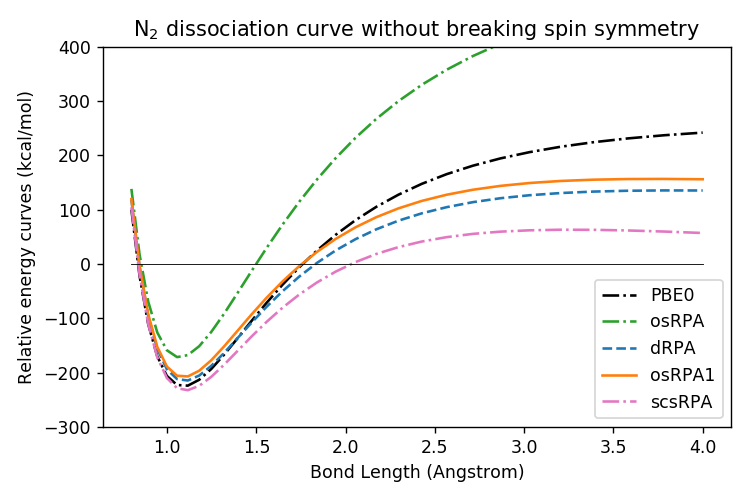

In [323]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x_list, y_list[0], c="black", linestyle="-.", label="PBE0")
ax.plot(x_list, y_list[1], c="C2", linestyle="-.", label="osRPA")
ax.plot(x_list, y_list[2], c="C0", linestyle="--", label="dRPA")
ax.plot(x_list, y_list[3], c="C1", linestyle="-", label="osRPA1")
ax.plot(x_list, y_list[4], c="C6", linestyle="-.", label="scsRPA")
ax.plot(x_list, np.zeros_like(x_list), c="black", linewidth=0.5)
ax.set_ylim(-300, 400)
ax.legend()
ax.set_xlabel("Bond Length (Angstrom)")
ax.set_ylabel("Relative energy curves (kcal/mol)")
ax.set_title("$\mathsf{N_2}$ dissociation curve without breaking spin symmetry")
fig.tight_layout()

由于 CCSD 与 CASSCF 的收敛情况似乎容易存在问题，因此这里仅仅计算了这五条曲线。

[^Zhang-Xu.JPCL.2019.10]: Zhang, I. Y.; Xu, X. Simultaneous Attenuation of Both Self-Interaction Error and Nondynamic Correlation Error in Density Functional Theory: A Spin-Pair Distinctive Adiabatic-Connection Approximation. J. Phys. Chem. Lett. 2019, 10 (10), 2617–2623. doi: [10.1021/acs.jpclett.9b00946](https://doi.org/10.1021/acs.jpclett.9b00946).